In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import re
from jupyterthemes import jtplot
from datetime import timedelta, datetime
import calendar
import plotly.express as px
jtplot.style()

# read in fullsample.csv

In [2]:
fs = pd.read_csv('../data/fullsample.csv')

In [3]:
fs = fs[(fs['BEGIN'] != 'Unknown') & (fs['END'] != 'Unknown')]

In [4]:
fs

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06T19:04:39,2021-09-05T19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09T16:52:51,2021-09-07T20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17T07:45:07,2021-09-10T16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0
5,31364111_3,COMPLETED,2021-08-17T07:45:07,2021-09-06T16:17:34,16384Mn,9708.04M,24-09:00:00,20-08:32:27,1,1,production,0:0
...,...,...,...,...,...,...,...,...,...,...,...,...
7395880,25493434,COMPLETED,2020-10-31T23:39:00,2020-10-31T23:40:46,2000Mn,0.09M,2-00:00:00,00:01:46,1,1,sam,0:0
7395881,25493435,COMPLETED,2020-10-31T23:39:13,2020-10-31T23:40:38,2000Mn,187.92M,2-00:00:00,00:01:25,1,1,sam,0:0
7395882,25493476,COMPLETED,2020-10-31T23:46:29,2020-10-31T23:49:43,4096Mc,803.97M,12:00:00,00:03:14,1,1,production,0:0
7395883,25493515,COMPLETED,2020-10-31T23:49:44,2020-10-31T23:51:40,2000Mn,0.09M,2-00:00:00,00:01:56,1,1,sam,0:0


# convert appropriate columns to datetime

In [5]:
dt_converts = ['BEGIN', 'END']

for col in dt_converts:
    fs[col] = pd.to_datetime(fs[col])

# filter down to COMPLETED state with 0:0: fscomp

In [6]:
# Insight: one instance of 9204 cancallation
fs.loc[fs['STATE'] == 'CANCELLED by 9204', 'EXITCODE'].value_counts()

1:0    1
Name: EXITCODE, dtype: int64

In [7]:
# Insight: all COMPLETED states are exit code 0:0
fs.loc[fs['STATE'] == 'COMPLETED', 'EXITCODE'].value_counts()

0:0    7375084
Name: EXITCODE, dtype: int64

In [8]:
# filter down to only COMPLETED state
fscomp = fs[fs['STATE'] == 'COMPLETED']

In [9]:
fscomp.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
1,30853133,COMPLETED,2021-08-06 11:36:09,2021-09-05 11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06 19:04:39,2021-09-05 19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09 16:52:51,2021-09-07 20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17 07:45:07,2021-09-10 16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0
5,31364111_3,COMPLETED,2021-08-17 07:45:07,2021-09-06 16:17:34,16384Mn,9708.04M,24-09:00:00,20-08:32:27,1,1,production,0:0


# get rolling counts of completions per hour

In [10]:
comp_per_hour = (fscomp.set_index('END')
                       .sort_values('END', ascending = True)
                       .rolling('1h')
                        ['JOBID']
                        .count()
                )

# get overall completions per hour for fs: 826.4 completions per hour

In [11]:
# define function to calculate total hours of a timedelta
def td_hours(timedelta):
    hours = timedelta.days*24 + timedelta.seconds/3600
    return hours

In [19]:
# overall completions per hour for fs
completions = len(fscomp)
time_diff = (fs['END'].max() - fs['END'].min())
jobs_per_hour = completions/td_hours(time_diff)
print(round(jobs_per_hour, 1), 'completions per hour')

826.4 completions per hour


# get completions per hour by week and analyze the change over the year

In [46]:
comp_per_hour_by_week = (fscomp.groupby(
                                    pd.Grouper(key = 'END', freq = 'W')) # Group by week
                                 ['JOBID'] # Counting job ids
                                 .count()/168 # divide count by 168 hours in a week
                        )

In [47]:
# display with renamed columns
comp_per_hour_by_week = (comp_per_hour_by_week.reset_index()
                                              .rename(columns = {'END': 'WEEK OF', 
                                                                 'JOBID': 'COMPLETIONS PER HOUR'}
                                                     )
                        )

## August and September 2021 seem to have higher completions per hour than the rest of the months. (We may be able to include October 2020 here, too, which makes me wonder whether the start of the school year has the highest demand.)

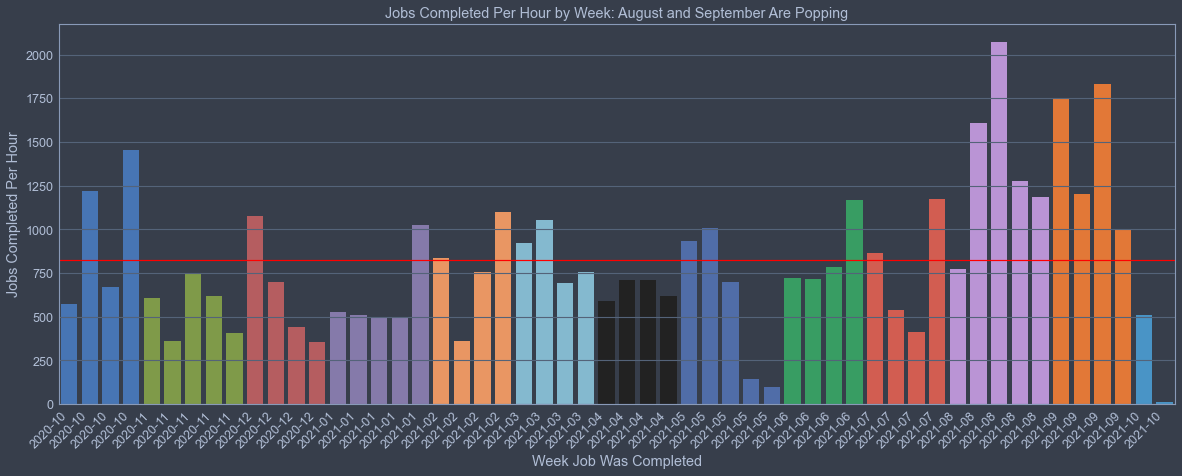

In [48]:
# Plot completions per hour by week, colored by month
fig, ax = plt.subplots(figsize=(20,7))

x_dates = comp_per_hour_by_week['WEEK OF'].dt.strftime('%Y-%m')

sns.barplot(x = 'WEEK OF',
            y = 'COMPLETIONS PER HOUR',
            data = comp_per_hour_by_week,
            ax = ax,
            hue = x_dates,
            dodge = False
           )


ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.get_legend().remove()
ax.axhline(jobs_per_hour, color = 'red')
ax.set(xlabel = 'Week Job Was Completed',
       ylabel = 'Jobs Completed Per Hour',
       title = 'Jobs Completed Per Hour by Week: August and September Are Popping')
plt.show()

## trendline of completions per hour by week shows gradual increase over the year.

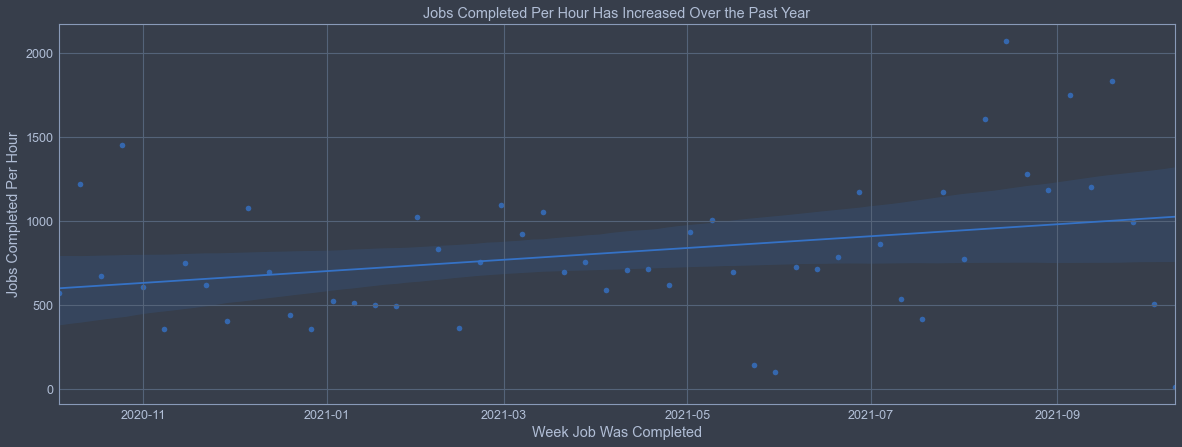

In [50]:
# Plot completions per hour by week along with trendline, which shows gradual increase over the year
fig, ax = plt.subplots(figsize=(20,7))

ax.xaxis.update_units(comp_per_hour_by_week['WEEK OF'])

sns.regplot(x = ax.xaxis.convert_units(comp_per_hour_by_week['WEEK OF']),
            y = 'COMPLETIONS PER HOUR',
            data = comp_per_hour_by_week,
            ax = ax,
            #hue = x_dates,
            #dodge = False
           )

ax.set(xlabel = 'Week Job Was Completed',
       ylabel = 'Jobs Completed Per Hour',
       title = 'Jobs Completed Per Hour Has Increased Over the Past Year')
plt.show()

## statsmodel regression confirms that the increasing trend is significant and has a slope of 1.15 jobs per hour per day (units are in days even though summary values are by week)

In [51]:
spent_model = (sm.GLM(endog = comp_per_hour_by_week['COMPLETIONS PER HOUR'],
                      exog = sm.add_constant(comp_per_hour_by_week['WEEK OF'].map(datetime.toordinal)),
                      family = sm.families.Gaussian())
               .fit())

print(spent_model.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     COMPLETIONS PER HOUR   No. Observations:                   54
Model:                              GLM   Df Residuals:                       52
Model Family:                  Gaussian   Df Model:                            1
Link Function:                 identity   Scale:                      1.6475e+05
Method:                            IRLS   Log-Likelihood:                -399.93
Date:                  Wed, 27 Oct 2021   Deviance:                   8.5672e+06
Time:                          21:27:31   Pearson chi2:                 8.57e+06
No. Iterations:                       3                                         
Covariance Type:              nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.481e+05   3.74e+05

# get jobs completed per hour by day, then summarize by day of the week

In [58]:
comp_per_hour_by_day = (fscomp.groupby(
                                    pd.Grouper(key = 'END', freq = 'D')) # Group by day
                                 ['JOBID'] # Counting job ids
                                 .count()/24 # divide count by 24 hours in a day
                        )

In [60]:
# display with renamed columns
comp_per_hour_by_day = (comp_per_hour_by_day.reset_index()
                                              .rename(columns = {'END': 'DAY', 
                                                                 'JOBID': 'COMPLETIONS PER HOUR'}
                                                     )
                        )

In [67]:
# Add weekday and weekday number to completions per hour by day
comp_per_hour_by_day['WEEKDAY'] = comp_per_hour_by_day['DAY'].apply(lambda x: calendar.day_name[x.weekday()])
comp_per_hour_by_day['WEEKDAY NUMBER'] = comp_per_hour_by_day['DAY'].apply(lambda x: x.weekday()+1)
comp_per_hour_by_day

,DAY,COMPLETIONS PER HOUR,WEEKDAY,WEEKDAY NUMBER
0,2020-10-01,1385.958333,Thursday,4
1,2020-10-02,1264.833333,Friday,5
2,2020-10-03,639.416667,Saturday,6
3,2020-10-04,730.500000,Sunday,7
4,2020-10-05,1004.958333,Monday,1
...,...,...,...,...
367,2021-10-03,65.041667,Sunday,7
368,2021-10-04,25.583333,Monday,1
369,2021-10-05,30.291667,Tuesday,2
370,2021-10-06,11.041667,Wednesday,3


## summary of weekday jobs per hour shows highest volume of completions early in the work week (Monday - Wednesay).

In [70]:
# Aggregate by weekday
comp_per_hour_weekday = comp_per_hour_by_day.groupby(['WEEKDAY NUMBER', 'WEEKDAY'], as_index = False)['COMPLETIONS PER HOUR'].mean()
comp_per_hour_weekday

,WEEKDAY NUMBER,WEEKDAY,COMPLETIONS PER HOUR
0,1,Monday,878.555031
1,2,Tuesday,1019.834906
2,3,Wednesday,926.651730
3,4,Thursday,795.691358
4,5,Friday,805.452044
5,6,Saturday,664.910377
6,7,Sunday,691.913522


## bar chart shows same result, with Monday - Wednesday as only days above the overall average completions per hour (red line) calculated earlier. Weekend completions per hour look significantly low.

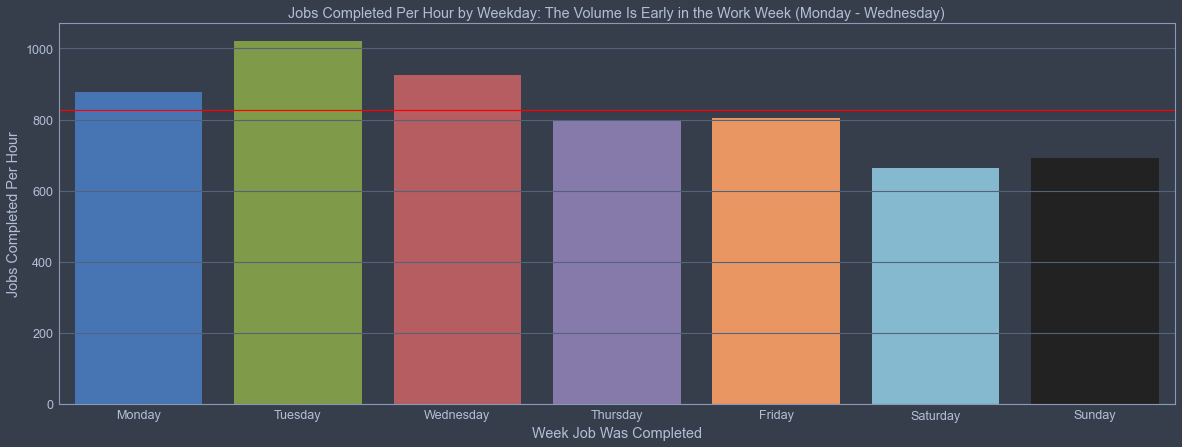

In [76]:
# Plot completions per hour by weekday
fig, ax = plt.subplots(figsize=(20,7))

sns.barplot(x = 'WEEKDAY',
            y = 'COMPLETIONS PER HOUR',
            data = comp_per_hour_weekday,
            ax = ax,
           )

ax.axhline(jobs_per_hour, color = 'red')
ax.set(xlabel = 'Week Job Was Completed',
       ylabel = 'Jobs Completed Per Hour',
       title = 'Jobs Completed Per Hour by Weekday: The Volume Is Early in the Work Week (Monday - Wednesday)')
plt.show()